## Урок 8. Кейс 2. Типы моделей для задачи оттока

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.subplots as sp
import xgboost as xgb
import dill

from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

In [2]:
def data_report(algorithm, testing_x, testing_y):
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print ("\n Classification report : \n", classification_report(testing_y, predictions))
    print ("Accuracy   Score : ", accuracy_score(testing_y, predictions))
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print ("Area under curve : ", model_roc_auc,"\n")
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
    
    #plot roc curve
    trace1 = go.Scatter(x=fpr, y=tpr)
    fig = sp.make_subplots(rows=1, cols=1)
    fig.append_trace(trace1, 1, 1)
   
    fig['layout'].update(showlegend=False, title="roc auc", autosize=False, height=500, width=500)
    fig["layout"]["xaxis1"].update(dict(title="false positive rate"))
    fig["layout"]["yaxis1"].update(dict(title="true positive rate"))
    py.iplot(fig)

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [4]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))
    _, ax = plt.subplots(1,1)

    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

#### 1. Скачать любой понравившийся вам датасет с UCI repository(можете даже свой какой-то взять) и сразу же разделите его на тренировочную и тестовую выборки. Тестовую выборку сохраните на диск и больше не трогайте.

In [5]:
# https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star
data = pd.read_csv("pulsar_stars.csv")
data.head()

Mean of the integrated profile  \
0                       140.562500   
1                       102.507812   
2                       103.015625   
3                       136.750000   
4                        88.726562   

    Standard deviation of the integrated profile  \
0                                      55.683782   
1                                      58.882430   
2                                      39.341649   
3                                      57.178449   
4                                      40.672225   

    Excess kurtosis of the integrated profile  \
0                                   -0.234571   
1                                    0.465318   
2                                    0.323328   
3                                   -0.068415   
4                                    0.600866   

    Skewness of the integrated profile   Mean of the DM-SNR curve  \
0                            -0.699648                   3.199833   
1                            -0.515088                   1.677258   
2                             1.051164                   3.121237   
3                            -0.636238                   3.642977   
4                             1.123492                   1.178930   

    Standard deviation of the DM-SNR curve  \
0                                19.110426   
1                                14.860146   
2                                21.744669   
3                                20.959280   
4                                11.468720   

    Excess kurtosis of the DM-SNR curve   Skewness of the DM-SNR curve  \
0                              7.975532                      74.242225   
1                             10.576487                     127.393580   
2                              7.735822                      63.171909   
3                              6.896499                      53.593661   
4                             14.269573                     252.567306   

   target_class  
0             0  
1             0  
2             0  
3             0  
4             0

In [6]:
target_name = 'target_class'
feature_names = data.columns.drop(target_name).tolist()

In [7]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=1)

train_X = train_data[feature_names] 
train_Y = train_data[target_name]
test_X = test_data[feature_names] 
test_Y = test_data[target_name]

In [8]:
#save test
test_X.to_csv("X_test.csv", index=None)
test_Y.to_csv("y_test.csv", index=None)
#save train
train_X.to_csv("X_train.csv", index=None)
train_Y.to_csv("y_train.csv", index=None)

#### 2. Провести EDA (exploratory data analysis: histograms, boxplots - visualization, etc). Например

In [9]:
print ("Rows:", train_data.shape[0])
print ("Columns:", train_data.shape[1])
print ("\nFeatures:\n", train_data.columns.tolist())
print ("\nMissing values:", train_data.isnull().sum().values.sum())
print ("\nUnique values:\n", train_data.nunique())

Rows: 12528
Columns: 9

Features:
 [' Mean of the integrated profile', ' Standard deviation of the integrated profile', ' Excess kurtosis of the integrated profile', ' Skewness of the integrated profile', ' Mean of the DM-SNR curve', ' Standard deviation of the DM-SNR curve', ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve', 'target_class']

Missing values: 0

Unique values:
  Mean of the integrated profile                   7201
 Standard deviation of the integrated profile    12512
 Excess kurtosis of the integrated profile       12528
 Skewness of the integrated profile              12528
 Mean of the DM-SNR curve                         7226
 Standard deviation of the DM-SNR curve          12524
 Excess kurtosis of the DM-SNR curve             12525
 Skewness of the DM-SNR curve                    12525
target_class                                         2
dtype: int64


In [10]:
train_data.describe()

Mean of the integrated profile  \
count                     12528.000000   
mean                        111.172769   
std                          25.604499   
min                           5.812500   
25%                         100.921875   
50%                         115.007812   
75%                         127.197266   
max                         192.617188   

        Standard deviation of the integrated profile  \
count                                   12528.000000   
mean                                       46.489071   
std                                         6.834575   
min                                        24.772042   
25%                                        42.377202   
50%                                        46.915724   
75%                                        50.969813   
max                                        98.778911   

        Excess kurtosis of the integrated profile  \
count                                12528.000000   
mean                                     0.479376   
std                                      1.070151   
min                                     -1.876011   
25%                                      0.027078   
50%                                      0.224054   
75%                                      0.476432   
max                                      8.069522   

        Skewness of the integrated profile   Mean of the DM-SNR curve  \
count                         12528.000000               12528.000000   
mean                              1.799634                  12.291059   
std                               6.282700                  28.707428   
min                              -1.791886                   0.213211   
25%                              -0.186198                   1.934783   
50%                               0.198160                   2.816054   
75%                               0.928735                   5.507734   
max                              68.101622                 223.392140   

        Standard deviation of the DM-SNR curve  \
count                             12528.000000   
mean                                 26.328175   
std                                  19.380783   
min                                   7.370432   
25%                                  14.474361   
50%                                  18.522063   
75%                                  28.554101   
max                                 110.642211   

        Excess kurtosis of the DM-SNR curve   Skewness of the DM-SNR curve  \
count                          12528.000000                   12528.000000   
mean                               8.288197                     104.214695   
std                                4.480729                     106.360406   
min                               -3.139270                      -1.976976   
25%                                5.732624                      34.370645   
50%                                8.405242                      82.311506   
75%                               10.656774                     137.959039   
max                               34.539844                    1191.000837   

       target_class  
count  12528.000000  
mean       0.091715  
std        0.288634  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [11]:
train_data[target_name].value_counts()

0    11379
1     1149
Name: target_class, dtype: int64

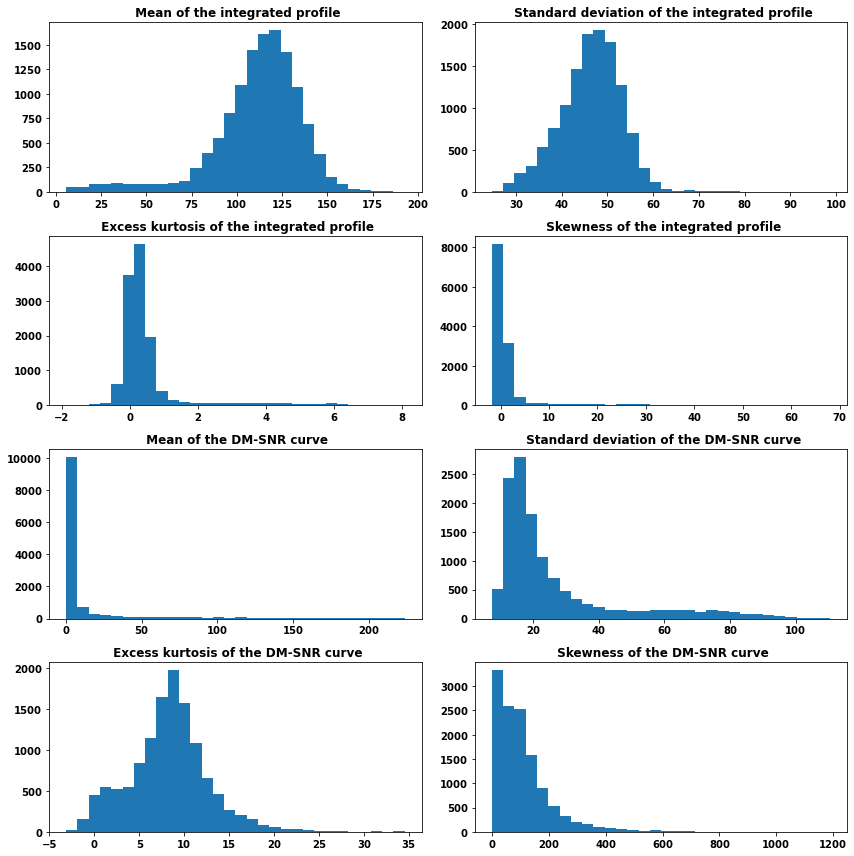

In [12]:
fig, axs = plt.subplots(4, 2, figsize = (12, 12))
ax = axs.flatten()
for i, c in enumerate(feature_names):
    ax[i].hist(train_data[c], bins=30, label="Data")
    ax[i].set_title(c)
fig.tight_layout()

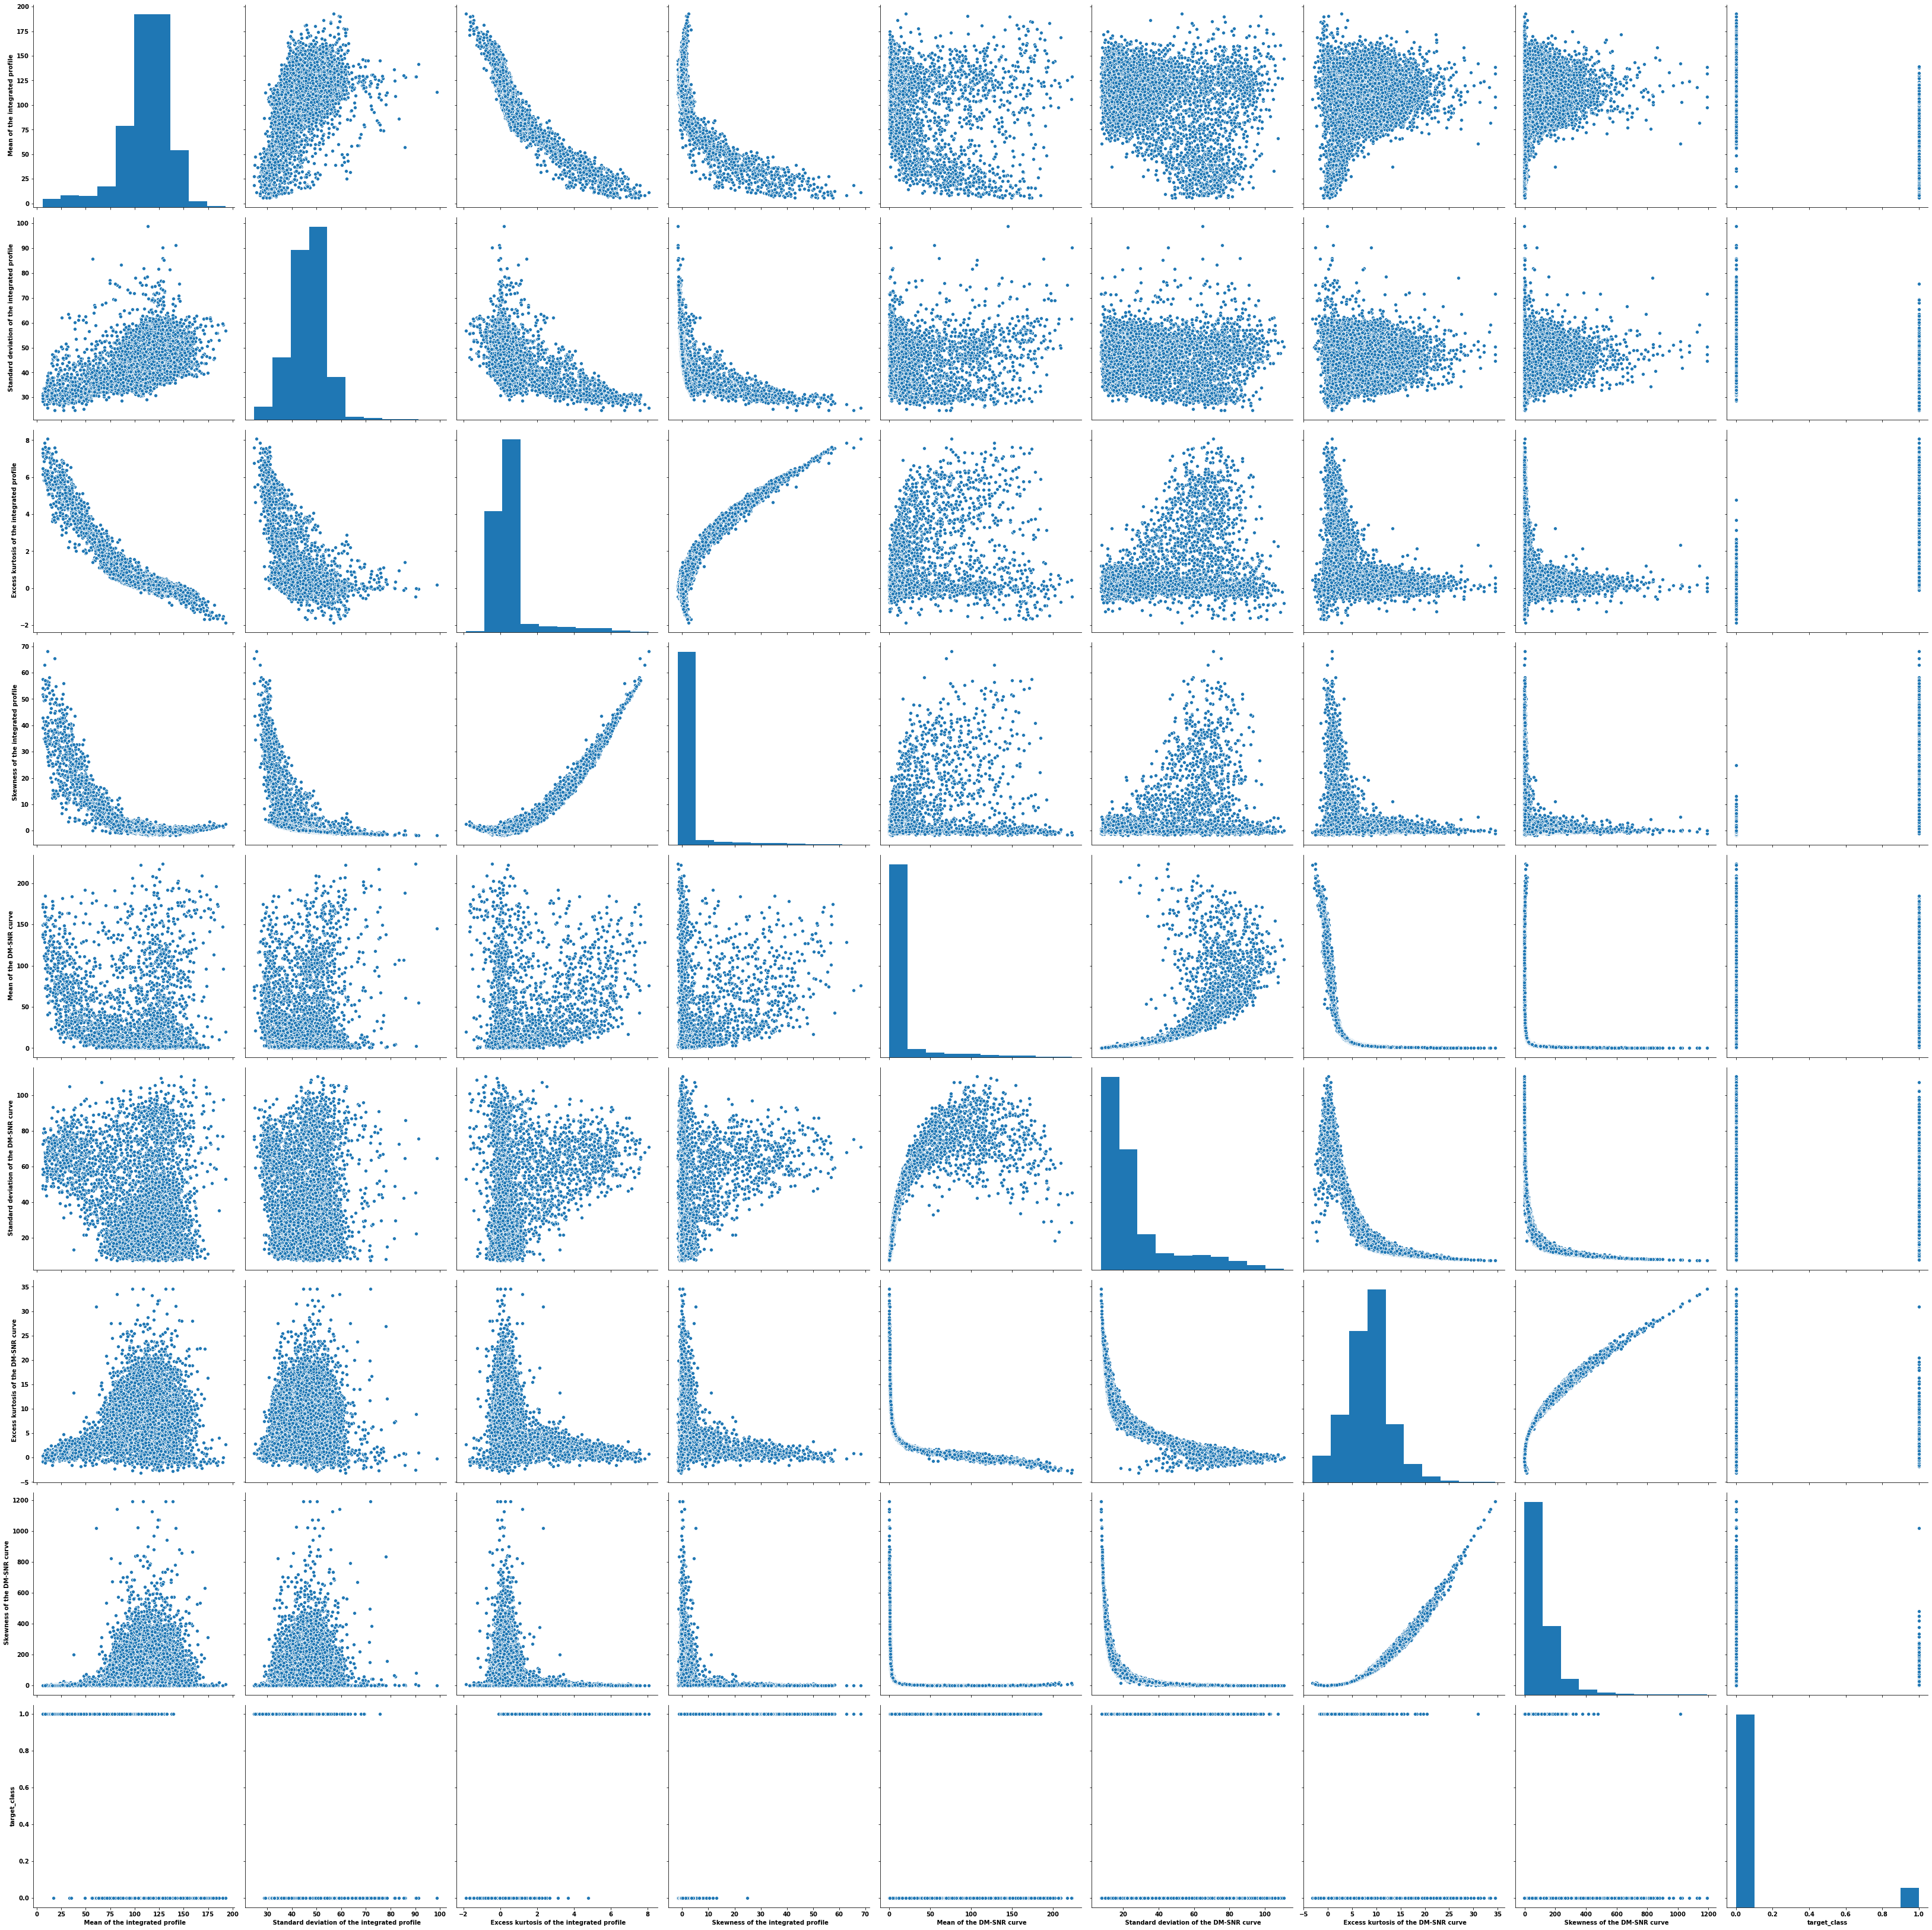

In [13]:
sns.pairplot(train_data, height=5)

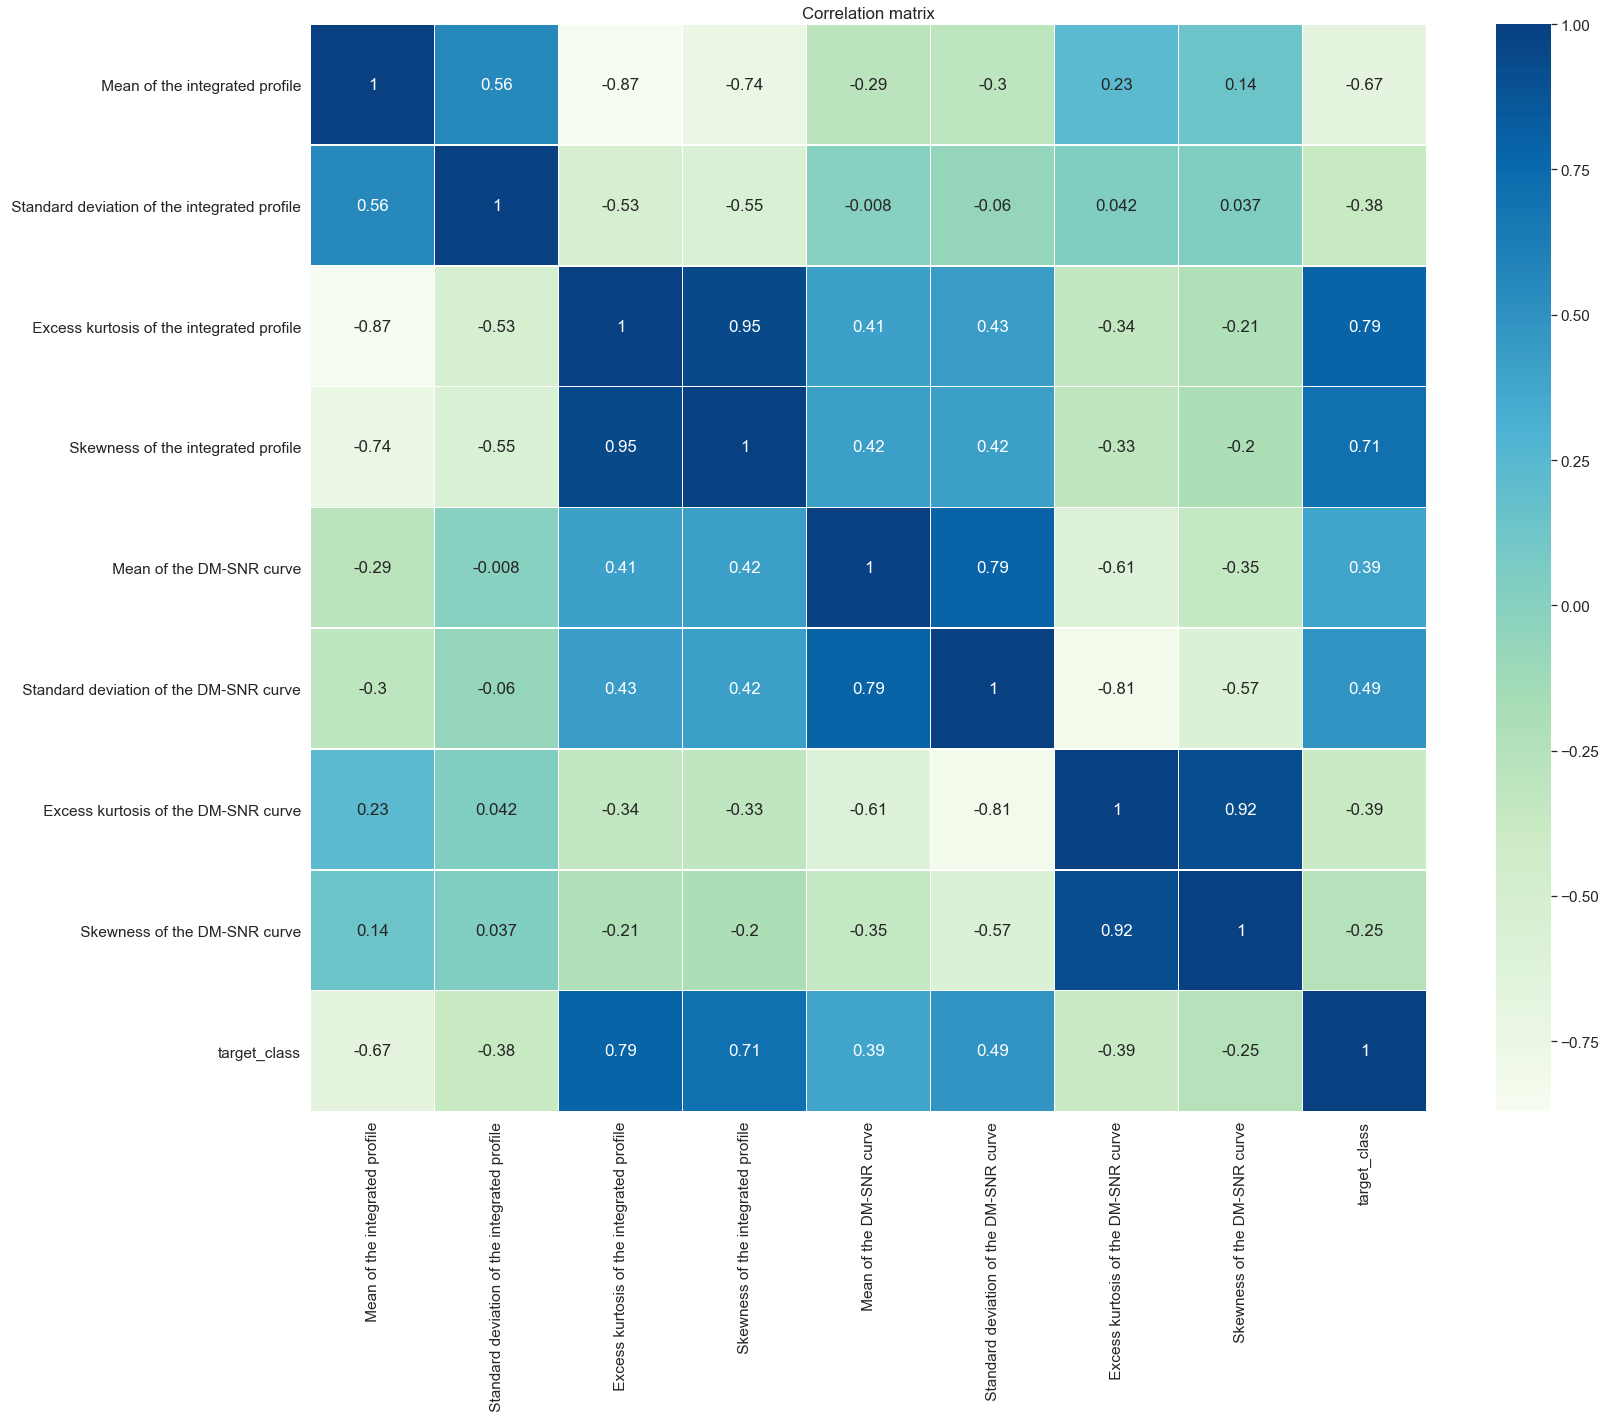

In [14]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
sns.heatmap(train_data.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

#### 3. Сделать feature engineering. При этом постарайтесь «завернуть» ваш код для преобразования данных в классы или функции (пример Transformer как в ноутбуке).

In [15]:
# Балансировка
df_for_balancing = pd.concat([train_X, train_Y], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    11379
1    10341
Name: target_class, dtype: int64

In [16]:
train_X = df_balanced.drop(columns=target_name)
train_Y = df_balanced[target_name]

In [17]:
# Суммирование признаков
class FeatureSummation(BaseEstimator, TransformerMixin):
    def __init__(self, feature1, feature2, new_feature):
        self.feature1 = feature1 
        self.feature2 = feature2
        self.new_feature = new_feature

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X[self.feature1] * 100 + X[self.feature2], columns = [self.new_feature])    

In [18]:
ficha = Pipeline([('ficha', FeatureSummation(feature1=' Excess kurtosis of the integrated profile',
                                             feature2=' Standard deviation of the DM-SNR curve',
                                             new_feature='ficha')),
                  ('standard', StandardScaler())
                 ])

In [19]:
feats = FeatureUnion([('ficha', ficha),
                     ])

In [20]:
feature_names = ['ficha']

#### 4. Обучить базовую модель (любую - на ваш выбор). При этом нужно использовать cross validation

In [21]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [22]:
hyperparameters = { 'classifier__max_depth': [3],
                    'classifier__n_estimators': [100]
                  }
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
clf.fit(train_X, train_Y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('ficha',
                                                                        Pipeline(steps=[('ficha',
                                                                                         FeatureSummation(feature1=' '
                                                                                                                   'Excess '
                                                                                                                   'kurtosis '
                                                                                                                   'of '
                                                                                                                   'the '
                                                                                                                   'integrated '
       

#### 5. Посчитайте разные метрики качества на cross-validation, отрисуйте графики (roc auc)

In [23]:
data_report(clf.best_estimator_, train_X, train_Y)


 Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     11379
           1       0.97      0.90      0.93     10341

    accuracy                           0.94     21720
   macro avg       0.94      0.93      0.94     21720
weighted avg       0.94      0.94      0.94     21720

Accuracy   Score :  0.9365101289134439
Area under curve :  0.9347482968909411 



#### 6. Сделать подбор гиперпараметров с помощью той же самой cross-validation.

In [24]:
classifiers = [
    SVC(),
    SGDClassifier(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier()
]

In [25]:
for clf in classifiers:
    pipeline.set_params(classifier=clf)
    scores = cross_validate(pipeline, train_X, train_Y, scoring='roc_auc', cv=5)
    #print(scores)
    print('----------------------')
    print(str(clf))
    print('----------------------')
    pprint('Leaderboard score - mean auc test '+str((scores['test_score'].mean())))

----------------------
SVC()
----------------------
'Leaderboard score - mean auc test 0.9604104149176017'
----------------------
SGDClassifier()
----------------------
'Leaderboard score - mean auc test 0.9731410499072959'
----------------------
KNeighborsClassifier()
----------------------
'Leaderboard score - mean auc test 0.988444142916079'
----------------------
DecisionTreeClassifier()
----------------------
'Leaderboard score - mean auc test 0.9873012804418779'
----------------------
ExtraTreeClassifier()
----------------------
'Leaderboard score - mean auc test 0.9881360783329148'
----------------------
RandomForestClassifier()
----------------------
'Leaderboard score - mean auc test 0.989577789011418'
----------------------
GradientBoostingClassifier()
----------------------
'Leaderboard score - mean auc test 0.9874096909904561'
----------------------
AdaBoostClassifier()
----------------------
'Leaderboard score - mean auc test 0.9773585713562966'
----------------------
XGBC

In [26]:
# Можем теперь выбрать лучшую модель и поперебирать ее параметры
pipeline = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier()),
])

hyperparameters = { 'classifier__max_depth': [1, 2, 3, 4, 5],
                    'classifier__n_estimators': [10, 50, 100, 150, 200],
                  }
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
 
# Fit and tune model
clf.fit(train_X, train_Y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('ficha',
                                                                        Pipeline(steps=[('ficha',
                                                                                         FeatureSummation(feature1=' '
                                                                                                                   'Excess '
                                                                                                                   'kurtosis '
                                                                                                                   'of '
                                                                                                                   'the '
                                                                                                                   'integrated '
       

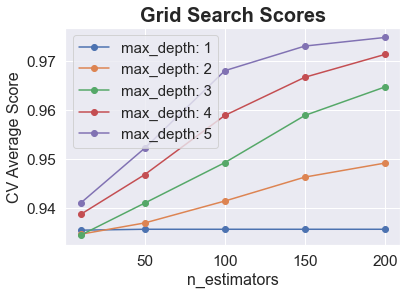

In [27]:
plot_grid_search(clf.cv_results_, 
                 hyperparameters['classifier__n_estimators'], 
                 hyperparameters['classifier__max_depth'], 
                 'n_estimators', 
                 'max_depth')

In [28]:
clf.best_params_

{'classifier__max_depth': 5, 'classifier__n_estimators': 200}

In [29]:
data_report(clf.best_estimator_, train_X, train_Y)


 Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     11379
           1       0.98      0.99      0.99     10341

    accuracy                           0.99     21720
   macro avg       0.99      0.99      0.99     21720
weighted avg       0.99      0.99      0.99     21720

Accuracy   Score :  0.987891344383057
Area under curve :  0.9881745757310818 



In [30]:
# Судя по всему модель переобучилась

In [31]:
# Обучим финальную модель
pipeline = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(max_depth=clf.best_params_['classifier__max_depth'],
                                     n_estimators=clf.best_params_['classifier__n_estimators'])),
])

pipeline.fit(train_X, train_Y)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ficha',
                                                 Pipeline(steps=[('ficha',
                                                                  FeatureSummation(feature1=' '
                                                                                            'Excess '
                                                                                            'kurtosis '
                                                                                            'of '
                                                                                            'the '
                                                                                            'integrated '
                                                                                            'profile',
                                                                                   feature2=' '
                                  

#### 7. Сохраните вашу модель на диск

In [32]:
with open("model_trained_XGB.dill", "wb") as f:
    dill.dump(pipeline, f)